### IMPORTING LIBRARIES

In [1]:
# =============================================================================
# SECTION 1: IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import Error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up visualization styles
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


### CONNECT TO MYSQL DATABASE

In [3]:
# =============================================================================
# SECTION 2: DATABASE CONNECTION
# =============================================================================

try:
    db = mysql.connector.connect(
        host="localhost",
        user="root",
        password="root",
        database="ecommerce_project"
    )
    if db.is_connected():
        print("Connected to MySQL database successfully!")
        cur = db.cursor()
except mysql.connector.Error as e:
    print(f"Error connecting to MySQL: {e}")

Connected to MySQL database successfully!


### EXPLORE ALL TABLES AND SHOW BASIC STATISTICS

In [5]:
# =============================================================================
# SECTION 3: DATA EXPLORATION
# =============================================================================

def explore_tables(db):

    cursor = db.cursor()
    
    print("="*60)
    print("DATABASE EXPLORATION")
    print("="*60)
    
    # List all tables
    cursor.execute("SHOW TABLES")
    tables = cursor.fetchall()
    table_names = [table[0] for table in tables]
    
    print(f"\n Tables in database: {len(table_names)}")
    
    # Count rows in each table
    for table_name in table_names:
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        count = cursor.fetchone()[0]
        print(f"• {table_name}: {count:,} rows")
    
    cursor.close()
    return table_names

# Run exploration
table_names = explore_tables(db)

DATABASE EXPLORATION

 Tables in database: 5
• customers: 89,316 rows
• order_items: 89,301 rows
• orders: 89,316 rows
• payments: 89,316 rows
• products: 27,449 rows


### LOAD ALL TABLES INTO PANDAS DATAFRAMES FOR EASIER ANALYSIS

In [7]:
# =============================================================================
# SECTION 4: LOAD DATA INTO PANDAS DATAFRAMES
# =============================================================================

def load_data_to_dataframes(db):

    print("="*60)
    print("LOADING DATA INTO PANDAS")
    print("="*60)
    
    # Load each table
    customers_df = pd.read_sql("SELECT * FROM customers", db)
    print(f"• Customers loaded: {len(customers_df):,} rows")
    
    products_df = pd.read_sql("SELECT * FROM products", db)
    print(f"• Products loaded: {len(products_df):,} rows")
    
    orders_df = pd.read_sql("SELECT * FROM orders", db)
    print(f"• Orders loaded: {len(orders_df):,} rows")
    
    order_items_df = pd.read_sql("SELECT * FROM order_items", db)
    print(f"• Order Items loaded: {len(order_items_df):,} rows")
    
    payments_df = pd.read_sql("SELECT * FROM payments", db)
    print(f"• Payments loaded: {len(payments_df):,} rows")
    
    return customers_df, products_df, orders_df, order_items_df, payments_df

# Load all data
customers_df, products_df, orders_df, order_items_df, payments_df = load_data_to_dataframes(db)

LOADING DATA INTO PANDAS
• Customers loaded: 89,316 rows
• Products loaded: 27,449 rows
• Orders loaded: 89,316 rows
• Order Items loaded: 89,301 rows
• Payments loaded: 89,316 rows


### CHECK DATA QUALITY FOR DATAFRAME

In [9]:
# =============================================================================
# SECTION 5: DATA QUALITY CHECK
# =============================================================================

def check_data_quality(df, df_name):

    print(f"\n{'='*60}")
    print(f"DATA QUALITY CHECK: {df_name}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"\n Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Column data types
    print(f"\n Column Data Types:")
    for col in df.columns:
        print(f"• {col}: {df[col].dtype}")
    
    # Missing values
    missing = df.isnull().sum()
    print(f"\n Missing Values:\n{missing}")
   
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n Duplicate Rows: {duplicates:,}")
    
    # First few rows
    print(f"\n First 3 Rows:")
    print(df.head(3))
    
    return df

# Check quality of each dataset
customers_df = check_data_quality(customers_df, "CUSTOMERS")
products_df = check_data_quality(products_df, "PRODUCTS")
orders_df = check_data_quality(orders_df, "ORDERS")
order_items_df = check_data_quality(order_items_df, "ORDER ITEMS")
payments_df = check_data_quality(payments_df, "PAYMENTS")


DATA QUALITY CHECK: CUSTOMERS

 Shape: 89,316 rows × 4 columns

 Column Data Types:
• customer_id: object
• customer_zip_code_prefix: object
• customer_city: object
• customer_state: object

 Missing Values:
customer_id                 0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

 Duplicate Rows: 0

 First 3 Rows:
    customer_id customer_zip_code_prefix      customer_city customer_state
0  000hN1Tzi4iN                    53110  alto do rodrigues             RN
1  001T2XiQONtX                    53350    duque de caxias             RJ
2  005aQnkeGglh                    98980            xanxere             SC

DATA QUALITY CHECK: PRODUCTS

 Shape: 27,449 rows × 6 columns

 Column Data Types:
• product_id: object
• product_category_name: object
• product_weight_g: float64
• product_length_cm: float64
• product_height_cm: float64
• product_width_cm: float64

 Missing Values:
product_id                 0
product_category_name   

### DATA CLEANING & TRANSFORMATION

In [11]:
# =============================================================================
# SECTION 6: DATA CLEANING & TRANSFORMATION 
# =============================================================================

# --- Orders Data ---
date_columns = [
    'order_purchase_timestamp', 'order_approved_at', 
    'order_delivered_timestamp', 'order_estimated_delivery_date']

for col in date_columns:
    if col in orders_df.columns:
        orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')

orders_df['purchase_year'] = orders_df['order_purchase_timestamp'].dt.year
orders_df['purchase_month'] = orders_df['order_purchase_timestamp'].dt.month
orders_df['purchase_day'] = orders_df['order_purchase_timestamp'].dt.day
orders_df['purchase_weekday'] = orders_df['order_purchase_timestamp'].dt.day_name()
orders_df['purchase_hour'] = orders_df['order_purchase_timestamp'].dt.hour

orders_df['delivery_time_days'] = (orders_df['order_delivered_timestamp'] - orders_df['order_purchase_timestamp']).dt.days
print (orders_df['delivery_time_days'].head(5))

# --- Order Items Data ---
order_items_df['total_item_price'] = (order_items_df['price'] + order_items_df['shipping_charges'])
print (order_items_df['total_item_price'].head(5))

# --- Products Data ---
products_df['product_volume_cm3'] = (products_df['product_length_cm'] * products_df['product_width_cm'] * products_df['product_height_cm'])
print (products_df['product_volume_cm3'].head(5))

products_df['product_category_name'].fillna('Unknown', inplace=True)

0     4.0
1    33.0
2     2.0
3     4.0
4    15.0
Name: delivery_time_days, dtype: float64
0     19.70
1    855.52
2    129.66
3    480.91
4    550.29
Name: total_item_price, dtype: float64
0      3840.0
1       714.0
2     30752.0
3    137592.0
4      3072.0
Name: product_volume_cm3, dtype: float64


### BUSINESS ANALYSIS - KEY METRICS

In [13]:
# =============================================================================
# SECTION 7: BUSINESS ANALYSIS - KEY METRICS
# =============================================================================

# --- Revenue ---
print("• REVENUE ANALYSIS:")
total_revenue = payments_df['payment_value'].sum()
avg_order_value = payments_df.groupby('order_id')['payment_value'].sum().mean()
print(f'Total Revenue: ${total_revenue:,.2f}')
print(f'Average Order Value: ${avg_order_value:,.2f}\n')

# --- Orders ---
print("• ORDER ANALYSIS:")
total_orders = orders_df['order_id'].count()
print(f'Toatl Orders: {total_orders:,}')

order_status_counts = orders_df['order_status'].value_counts()
print(f"Order Status Distribution:")
for status, count in order_status_counts.items():
    pct = (count / total_orders) * 100
    print(f"      ‣ {status}: {count:,} ({pct:.1f}%)")

# --- Customers ---
print("\n•  CUSTOMER ANALYSIS:")
total_customers = customers_df['customer_id'].count()
print(f'Total Customers: {total_customers}')
orders_per_customer = total_orders / total_customers
print(f'Average Order per Customer: {orders_per_customer:.2f}')

print('\nTop 5 Cities:')
top_cities = customers_df['customer_city'].value_counts().head(5)
print(top_cities.to_string())

# --- Products ---
print('\n• PRODUCT ANALYSIS:')
total_products = products_df['product_id'].count()
print(f"Total Products: {total_products:,}")

print('\nTop 5 Product categories:')
top_categories = products_df['product_category_name'].value_counts().head(5)
print(top_categories.to_string())

# --- Payments ---
print("\n• PAYMENT ANALYSIS:")
print('Payment Methods (%):')
payment_types = payments_df['payment_type'].value_counts(normalize=True)*100
print(payment_types.round(1).to_string())

print(f'\nAverage Payment Installments: {payments_df['payment_installments'].mean():.2f}')


• REVENUE ANALYSIS:
Total Revenue: $23,995,385.57
Average Order Value: $268.66

• ORDER ANALYSIS:
Toatl Orders: 89,316
Order Status Distribution:
      ‣ delivered: 87,428 (97.9%)
      ‣ shipped: 936 (1.0%)
      ‣ canceled: 409 (0.5%)
      ‣ processing: 273 (0.3%)
      ‣ invoiced: 266 (0.3%)
      ‣ unavailable: 2 (0.0%)
      ‣ approved: 2 (0.0%)

•  CUSTOMER ANALYSIS:
Total Customers: 89316
Average Order per Customer: 1.00

Top 5 Cities:
customer_city
sao paulo         14352
rio de janeiro     6248
belo horizonte     2426
brasilia           1778
curitiba           1421

• PRODUCT ANALYSIS:
Total Products: 27,449

Top 5 Product categories:
product_category_name
toys               20607
bed_bath_table       654
sports_leisure       624
furniture_decor      567
health_beauty        530

• PAYMENT ANALYSIS:
Payment Methods (%):
payment_type
credit_card    73.7
wallet         19.4
voucher         5.5
debit_card      1.4

Average Payment Installments: 2.97


### ADVANCED ANALYSIS - COMBINING TABLES

In [31]:
# =============================================================================
# SECTION 8: ADVANCED ANALYSIS - JOINS & AGGREGATIONS
# =============================================================================

# --- Top Selling Products ---
print("\n• TOP 10 SELLING PRODUCTS:")
top_products = order_items_df.merge(products_df, on='product_id')
product_sales = (
    top_products.groupby(['product_id', 'product_category_name'])
    .agg(unit_sold=('order_id','count'), total_revenue=('price', 'sum'))
    .reset_index()
    .sort_values('total_revenue', ascending=False)
)

# Group again by category to find total revenue per category
category_sales = (
    product_sales
    .groupby('product_category_name')
    .agg(
        total_revenue=('total_revenue', 'sum'),
        total_units_sold=('unit_sold', 'sum')
    )
    .reset_index()
    .sort_values('total_revenue', ascending=False)
)

print('\nTop 10 Selling Products:')
top10_categories = category_sales.head(10).to_string(index=False)
print(top10_categories)

# --- Top Customers by Spending (CLV) ---
print("\n• TOP 10 CUSTOMERS BY SPENDING:")
customer_orders = orders_df.merge(payments_df, on='order_id')
customer_spending = (
    customer_orders.groupby('customer_id')
    .agg(total_spent=('payment_value', 'sum'), order_count=('order_id','count'))
    .reset_index()
    .sort_values('total_spent', ascending=False)
    .merge(customers_df, on='customer_id')
)
print("\nTop 10 Customers by Spending:")
print(customer_spending[['customer_id', 'total_spent', 'order_count', 'customer_city']].head(10).to_string(index=False))

# --- Monthly Sales Trend ---
print("\n• MONTHLY SALES TREND:")
monthly_sales = orders_df.merge(payments_df, on ='order_id')
monthly_revenue = (
    monthly_sales.groupby('purchase_month')['payment_value']
    .sum()
    .reset_index(name='revenue')
)
month_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

monthly_revenue['month'] = monthly_revenue['purchase_month'].map(month_map).fillna('Unknown')

print("\nMonthly Sales Trend:")
print(monthly_revenue[['month', 'revenue']].to_string(index=False))



• TOP 10 SELLING PRODUCTS:

Top 10 Selling Products:
product_category_name  total_revenue  total_units_sold
                 toys    22979439.21             67012
      furniture_decor      753073.49              1760
         garden_tools      746590.63               807
       bed_bath_table      604534.89              2146
        health_beauty      596724.24              2351
        watches_gifts      584225.46              1196
       sports_leisure      547922.16              1837
            telephony      494999.59               912
computers_accessories      430532.98              1715
           housewares      415090.22              1340

• TOP 10 CUSTOMERS BY SPENDING:

Top 10 Customers by Spending:
 customer_id  total_spent  order_count  customer_city
bmv1Lg65SUWP      7274.88            1 rio de janeiro
Nz66V2TeAxAX      6929.31            1        tijucas
H1deBLRJV7r9      6922.21            1    carapicuiba
oW2VygXvCSzO      6922.21            1       salvador
r6BPYyz

### CREATING VISUALIZATIONS

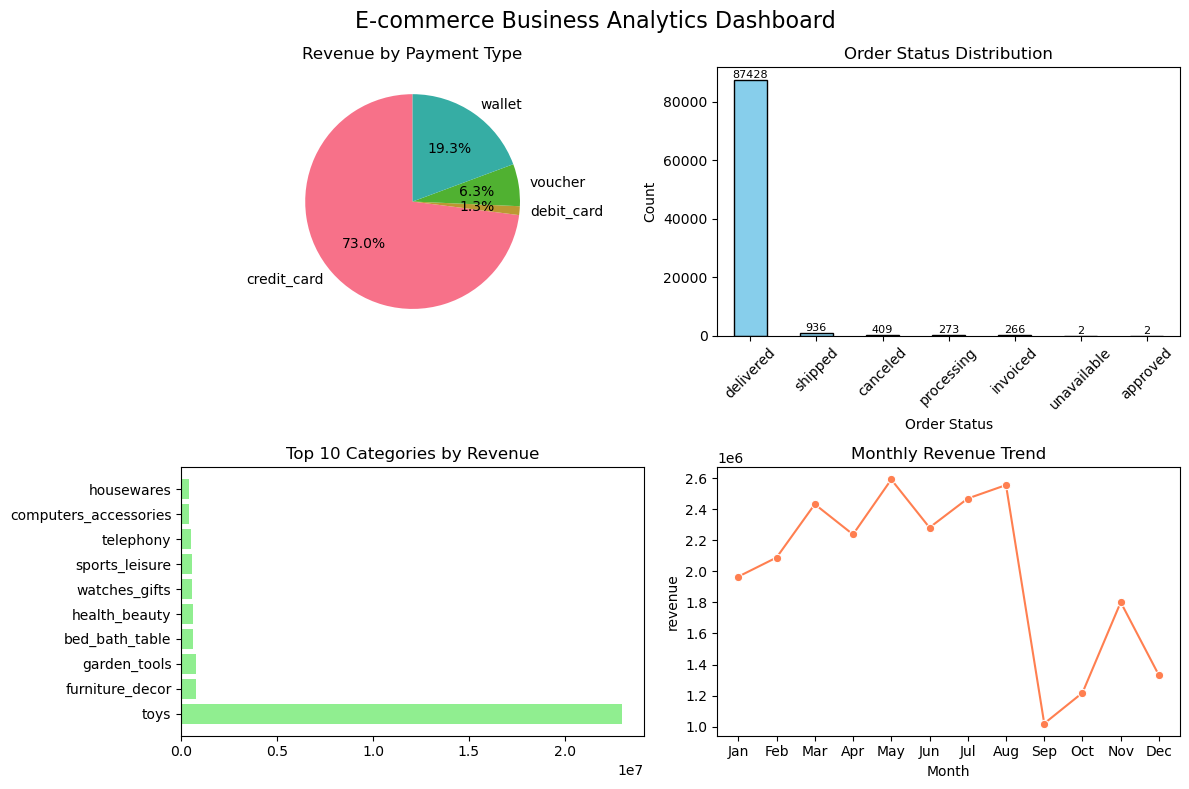

In [33]:
# =============================================================================
# SECTION 9: DATA VISUALIZATION
# =============================================================================

fig, axes = plt.subplots(2,2, figsize=(12,8))
fig.suptitle('E-commerce Business Analytics Dashboard', fontsize=16)

# 9.1 Revenue by Payment Type
payment_revenue = payments_df.groupby('payment_type')['payment_value'].sum().reset_index()
axes[0,0].pie(payment_revenue['payment_value'], labels=payment_revenue['payment_type'], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Revenue by Payment Type')

# 9.2 Order Status Distribution (Bar Chart - using bar_label)
bars = order_status_counts.plot(kind='bar', ax=axes[0,1], color='skyblue', edgecolor='black')
axes[0,1].set_title('Order Status Distribution')
axes[0,1].set_xlabel('Order Status')
axes[0,1].set_ylabel('Count')
axes[0,1].tick_params(axis='x', rotation=45)

# Add value labels on bars (simplest way)
axes[0,1].bar_label(bars.containers[0], fontsize=8)


# 9.3 Top 10 Categories by Revenue
category_revenue = top_products.groupby('product_category_name')['price'].sum().nlargest(10)
axes[1,0].barh(category_revenue.index, category_revenue.values, color='lightgreen')
axes[1,0].set_title('Top 10 Categories by Revenue')

# 9.4 Monthly Revenue Trend
sns.lineplot(data=monthly_revenue, x='month', y='revenue', marker='o', ax=axes[1,1], color='coral')
axes[1,1].set_title('Monthly Revenue Trend')
axes[1,1].set_xlabel('Month')

plt.tight_layout()
plt.show()


### PREPARING DATA FOR POWER BI

In [35]:
# =============================================================================
# SECTION 10: PREPARE DATA FOR POWER BI
# =============================================================================

# Create summary tables for Power BI

# 10.1 Sales Summary Table
sales_summary = (orders_df
                 .merge(order_items_df, on='order_id')
                 .merge(products_df, on='product_id')
                 .merge(customers_df, on='customer_id')
                 .merge(payments_df, on='order_id')
                )

# Select important columns for Power BI
powerbi_sales = sales_summary[[
    'order_id', 'customer_id', 'product_id', 'product_category_name',
    'order_status', 'order_purchase_timestamp', 'customer_city', 'customer_state',
    'price', 'shipping_charges', 'payment_value', 'payment_type',
    'purchase_year', 'purchase_month', 'purchase_weekday'
]]

# Save to CSV for Power BI import
powerbi_sales.to_csv('powerbi_sales_data.csv', index=False)
print("Sales data exported: 'powerbi_sales_data.csv'")

# 10.2 Customer Summary Table
customer_summary = customer_spending.merge(customers_df, on='customer_id')
customer_summary.to_csv('powerbi_customer_summary.csv', index=False)
print("Customer summary exported: 'powerbi_customer_summary.csv'")

# 10.3 Product Performance Table
product_performance = product_sales
product_performance.to_csv('powerbi_product_performance.csv', index=False)
print("Product performance exported: 'powerbi_product_performance.csv'")

print("\n• Data preparation for Power BI completed!")

Sales data exported: 'powerbi_sales_data.csv'
Customer summary exported: 'powerbi_customer_summary.csv'
Product performance exported: 'powerbi_product_performance.csv'

• Data preparation for Power BI completed!


### FINAL BUSINESS INSIGHTS & RECOMMENDATIONS

In [37]:
# =============================================================================
# SECTION 11: FINAL SUMMARY & INSIGHTS
# =============================================================================

print(f"""
≡ KEY FINDINGS:

1. REVENUE INSIGHTS:
    • Total Revenue: ${total_revenue:,.2f}
    • Average Order Value: ${avg_order_value:.2f}
    • Most Popular Payment: {payment_types.index[0]}
   
2. CUSTOMER INSIGHTS:
    • Total Customers: {total_customers:,}
    • Orders per Customers: {orders_per_customer:.2f}
    • Top Market: {top_cities.index[0]} with {top_cities.values[0]:,} customers 

3. PRODUCT INSIGHTS:
    • Total Products: {total_products:,}
    • Top Category: {top_categories.index[0]}
    • Best Selling Product Category: {product_sales.iloc[0]['product_category_name']}

4. OPERATIONAL INSIGHTS:
    • Average Delivery Time: {orders_df['delivery_time_days'].mean():.1f} days
    • Order Completion Rate: {(order_status_counts.get('delivered', 0) / total_orders * 100):.1f}%

RECOMMENDATIONS:
   1. Focus marketing on {top_cities.index[0]} - your biggest market
   2. Promote {payment_types.index[0]} payment method - most popular
   3. Optimize {top_categories.index[0]} category - high product count
   4. Target customers with multiple orders for loyalty programs
   5. Improve delivery time to increase customer satisfaction

""")


≡ KEY FINDINGS:

1. REVENUE INSIGHTS:
    • Total Revenue: $23,995,385.57
    • Average Order Value: $268.66
    • Most Popular Payment: credit_card
   
2. CUSTOMER INSIGHTS:
    • Total Customers: 89,316
    • Orders per Customers: 1.00
    • Top Market: sao paulo with 14,352 customers 

3. PRODUCT INSIGHTS:
    • Total Products: 27,449
    • Top Category: toys
    • Best Selling Product Category: toys

4. OPERATIONAL INSIGHTS:
    • Average Delivery Time: 12.0 days
    • Order Completion Rate: 97.9%

RECOMMENDATIONS:
   1. Focus marketing on sao paulo - your biggest market
   2. Promote credit_card payment method - most popular
   3. Optimize toys category - high product count
   4. Target customers with multiple orders for loyalty programs
   5. Improve delivery time to increase customer satisfaction


